Recording...
Recording finished.


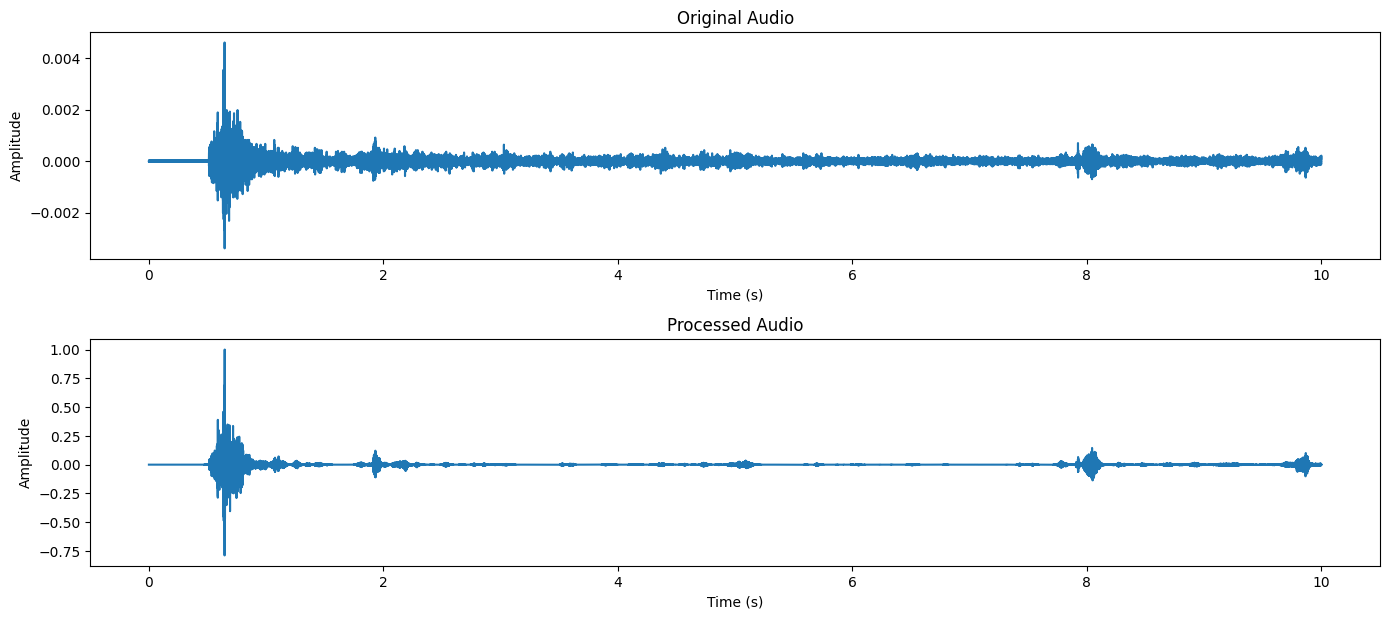

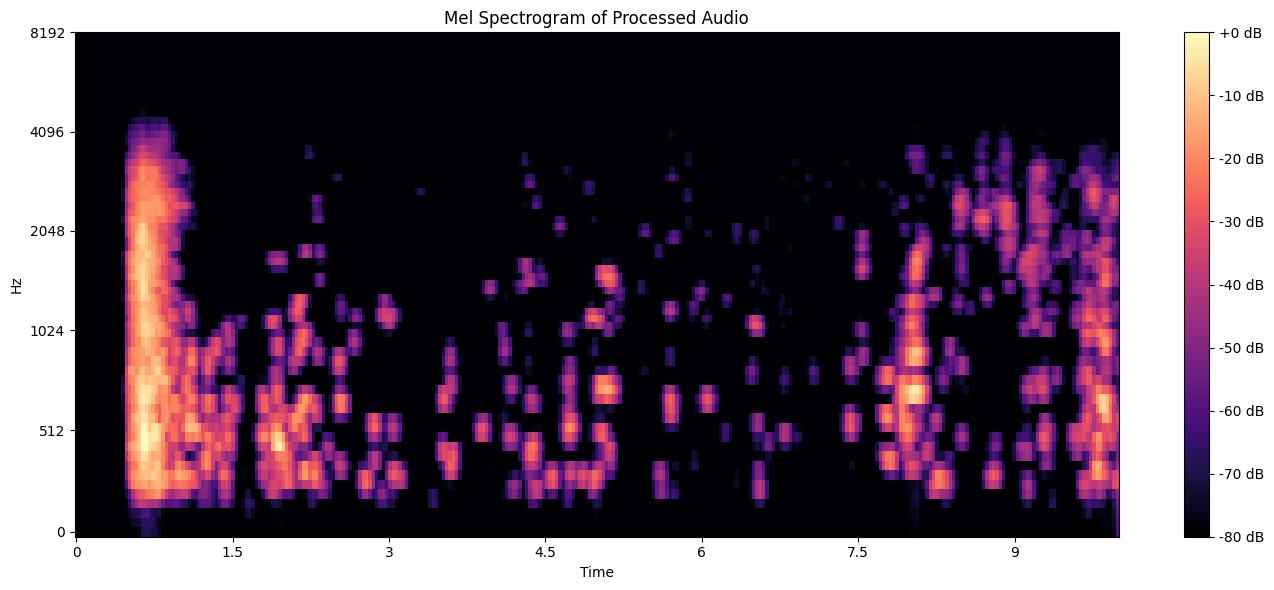

Playing Original Audio:


Playing Processed Audio:


In [2]:
import sounddevice as sd
import librosa
import numpy as np
import scipy.signal
import noisereduce as nr
import matplotlib.pyplot as plt
from IPython.display import Audio, display

SAMPLE_RATE = 16000
DURATION_SECONDS = 10 

def record_audio(duration, sample_rate):
    print("Recording...")
    recorded_audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    print("Recording finished.")
    return recorded_audio.flatten()

def denoise_and_filter(audio, sample_rate):
    denoised_audio = nr.reduce_noise(y=audio, sr=sample_rate, prop_decrease=1.0, time_mask_smooth_ms=60, freq_mask_smooth_hz=60)
    low_cutoff_freq = 300
    high_cutoff_freq = 3000
    b, a = scipy.signal.butter(10, [low_cutoff_freq / (sample_rate / 2), high_cutoff_freq / (sample_rate / 2)], btype='band')
    filtered_audio = scipy.signal.lfilter(b, a, denoised_audio)

    compressed_audio = np.log1p(np.abs(filtered_audio)) * np.sign(filtered_audio)

    normalized_audio = compressed_audio / np.max(np.abs(compressed_audio))
    
    return normalized_audio

def plot_waveform_and_spectrogram(original_audio, processed_audio, sample_rate):
    plt.figure(figsize=(14, 12))

    plt.subplot(4, 1, 1)
    plt.plot(np.arange(len(original_audio)) / sample_rate, original_audio)
    plt.title('Original Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 2)
    plt.plot(np.arange(len(processed_audio)) / sample_rate, processed_audio)
    plt.title('Processed Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=sample_rate, n_mels=64)
    db_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(db_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate)
    plt.title('Mel Spectrogram of Processed Audio')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

original_audio = record_audio(DURATION_SECONDS, SAMPLE_RATE)
processed_audio = denoise_and_filter(original_audio, SAMPLE_RATE)

plot_waveform_and_spectrogram(original_audio, processed_audio, SAMPLE_RATE)

print("Playing Original Audio:")
display(Audio(original_audio, rate=SAMPLE_RATE))
print("Playing Processed Audio:")
display(Audio(processed_audio, rate=SAMPLE_RATE))
